In [ ]:
"""
seleccion:
    'elitist'
    'roulette_wheel'
    'boltzmann'  usa pseudo-performance roulette_wheel
    'universal_selection'   
    'deterministic_tournament'
    'stochastic_tournament'
    'rank_based'    usa pseudo-performance roulette_wheel

crossover:
    'one_point'
    'two_point'
    'uniform'
    'annular'

mutation:
    'one_gene'
    'multi_gene'
    'multi_gene_mutation_uniform'
"""

#### Setup

In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.8e}'.format

import configparser
from collections import defaultdict
from src.character import Character, CharacterType 
from src.stats import random_stats
from src.genes import  encode_genes, decode_genes
from src.mutation import one_gene_mutation, multi_gene_mutation, multi_gene_mutation_uniform

import sys
sys.path.append("src")

from src.population import generate_init_population, eval_performace
from src.selection import stochastic_tournament_selection, deterministic_tournament_selection, add_relative_accumulate, elitist_selection, roulette_wheel_selection, universal_selection, boltzmann_selection, rank_based_selection
from src.crossover import single_point_crossover, two_point_crossover, uniform_crossover, annular_crossover, normalize_chromosome


In [4]:
from collections import namedtuple

def read_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    params = defaultdict(dict)
    for section in config.sections():
        for key, value in config.items(section):
            params[section][key] = value
    return params

#params = read_config('config_file.config')

def parameters():
    
    config_params = read_config('config_file.config')

    # Personaje 
    type = eval(config_params['CHARACTER']['type'])
    
    # sum( stats ) = 150
    maxStatsValue = eval(config_params['M']['m'])
    
    # N
    populationNumber = eval(config_params['N']['n'])
    # K
    k = eval(config_params['K']['k'])

    # Numero máximo de generaciones - criterio de corte
    numberOfGenerations = eval(config_params['GENERATIONS']['number'])
    
    # A%
    method1Percentage = eval(config_params['METHOD1PERCENTAGE']['percentage'])
    selectionMethod1 = eval(config_params['SELECTION_METHOD']['method1'])
    selectionMethod2 = eval(config_params['SELECTION_METHOD']['method2'])
   
    # CrossOver
    metodo_cruza = eval(config_params['metodo_cruza']['crossover'])
 
    # Mutation
    mutation_type = eval(config_params['MUTATION']['mutation_type'])
    mutation_rate = eval(config_params['MUTATION']['mutation_rate'])

    # B%
    methodReplacePercentage = eval(config_params['METHODRePERCENTAGE']['percentage'])
    metodo_reemplazo3 = eval(config_params['metodo_reemplazo']['metodo1'])
    metodo_reemplazo4 = eval(config_params['metodo_reemplazo']['metodo2'])

    cutCriteria = eval(config_params['CUT_CRITERIA']['criteria_type'])
    
    # Selector parameters
    # M
    tournament_size = eval(config_params['deterministic_tournament_selection']['tournament_size'])
    # stochastic_tournament_selection
    threhold = eval(config_params['stochastic_tournament_selection']['threshold'])
    # Boltzmann parameters
    boltzmannT_0 = eval(config_params['BOLTZMANN']['t_0'])
    boltzmannT_c = eval(config_params['BOLTZMANN']['t_c'])
    boltzmannM = eval(config_params['BOLTZMANN']['m'])

    Param = namedtuple('Param',[
        'character',
        'maxStatsValue',
        'populationNumber',
        'k',
        'numberOfGenerations',
        'method1Percentage',
        'selectionMethod1',
        'selectionMethod2',
        'metodo_cruza',
        'mutation_type',
        'mutation_rate',
        'methodReplacePercentage',
        'metodo_reemplazo3',
        'metodo_reemplazo4',
        'cutCriteria',
        'tournament_size',
        'threhold',
        'boltzmannT_0',
        'boltzmannT_c',
        'boltzmannM'
    ])    

    parametros = Param(
                character=type,
                maxStatsValue=maxStatsValue,
                populationNumber=populationNumber,
                k=k,
                numberOfGenerations=numberOfGenerations,
                method1Percentage=method1Percentage,
                selectionMethod1=selectionMethod1,
                selectionMethod2=selectionMethod2,
                metodo_cruza=metodo_cruza,
                mutation_type=mutation_type,
                mutation_rate=mutation_rate,
                methodReplacePercentage=methodReplacePercentage,
                metodo_reemplazo3=metodo_reemplazo3,
                metodo_reemplazo4=metodo_reemplazo4,
                cutCriteria=cutCriteria,
                tournament_size=tournament_size,
                threhold=threhold,
                boltzmannT_0=boltzmannT_0,
                boltzmannT_c=boltzmannT_c,
                boltzmannM=boltzmannM
    )

    return parametros

#p = parameters()


In [ ]:
"""
from src.character import Character, CharacterType 
import sys
sys.path.append("src")

from src.population import generate_init_population

#GENERACION 0

generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0
"""


In [ ]:
"""
# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
#generation_0.insert(0, 'generation', int(generacion))
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)
"""


#### Functions

In [ ]:

def method_selector(Kt, method1Percentage): 
    # Selecciono K individuos
    # Utilizo el porcentaje para cada método
    K1 = int(np.round(Kt * method1Percentage))
    K2 = Kt - K1
    return K1, K2

#k1, k2 = method_selector(p.k, p.method1Percentage)

In [ ]:
#current_generation = generation_0
#generacion = 0

In [ ]:
def selection_method(poblacion, ki, params, method, generation):

    if(method == 'elitist'):
        selected = elitist_selection(poblacion, ki)
    elif(method == 'roulette_wheel'):
        selected = roulette_wheel_selection(poblacion, ki)
    elif(method == 'boltzmann'):
        selected = boltzmann_selection(poblacion, ki, generation, params.boltzmannT_0,params.boltzmannT_c,params.boltzmannM)
    elif(method == 'universal_selection'):
        selected = universal_selection(poblacion, ki)
    elif(method == 'deterministic_tournament'):
        selected = deterministic_tournament_selection(poblacion, params.tournament_size, ki)
    elif(method == 'stochastic_tournament'):
        selected = stochastic_tournament_selection(poblacion, ki, params.threhold)
    elif(method == 'rank_based'):
        selected = rank_based_selection(poblacion, ki)
    return selected
"""
# SELECCION DE PADRES
generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

# SELECCION TOTAL: K padres
selection_total = pd.concat([generacion_sel1, generacion_sel2])

selection_total.drop(columns=['performance_relative'], inplace=True)
selection_total.drop(columns=['performance_accumulated'], inplace=True)
selection_total = selection_total.sort_values(by='performance', ascending=False)
selection_total.reset_index(drop=True, inplace=True)
"""


In [ ]:
#cromosomas = encode_genes(selection_total)

#cromosomas

In [ ]:
def crossover_method(poblacion, method):
    
    if(method == 'one_point'):
        crossed = single_point_crossover(poblacion)
    elif(method == 'two_point'):
        crossed = two_point_crossover(poblacion)
    elif(method == 'uniform'):
        crossed = uniform_crossover(poblacion)
    elif(method == 'annular'):
        crossed = annular_crossover(poblacion)
    
    return crossed

#crossed_result = crossover_method(cromosomas, p.metodo_cruza)

#crossed_result

In [ ]:
def mutation_method(poblacion, rate, method):
    
    if(method == 'one_gene'):
        mutated = one_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene'):
        mutated = multi_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene_mutation_uniform'):
        mutated = multi_gene_mutation_uniform(poblacion, rate)
    
    return mutated

#mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)

#mutation_result

In [ ]:
#cromosomas_norm = normalize_chromosome(mutation_result)

#cromosomas_norm

In [ ]:
"""
cromosomas_norm_decode = decode_genes(cromosomas_norm)
offspring = eval_performace(cromosomas_norm_decode,p.character)

offspring = offspring.sort_values(by='performance', ascending=False)
offspring.reset_index(drop=True, inplace=True)

offspring

"""

In [ ]:
"""
# REEMPLAZO
# padres:  selection_total de tamaño K
# hijos: offspring  de tamaño K
# tomo K de los hijos
k_reemplazo_metodo3 = p.k
# el resto para completar N
k_reemplazo_metodo4 = p.populationNumber - p.k

# SELECCION DE PADRES
generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)

# SELECCION TOTAL: K padres
new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

new_generation.drop(columns=['performance_relative'], inplace=True)
new_generation.drop(columns=['performance_accumulated'], inplace=True)
new_generation = new_generation.sort_values(by='performance', ascending=False)
new_generation.reset_index(drop=True, inplace=True)

new_generation
"""

In [ ]:
"""
generacion += 1
# GUARDO EL MAS APTO DE LA GENERACION NUEVA
# Escribe la poblacion inicial.

#new_generation.insert(0, 'generation', int(generacion))
new_generation['generation'] = generacion
mas_apto_NG = new_generation.head(1)
mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)
"""

#### Selections

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generation_0.to_csv(f'generation0.csv', mode='w', index=False)
generation_0

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

elitist_selection = elitist_selection(generation_0,p.k)
elitist_selection.to_csv(f'elitist_selection.csv', mode='w', index=False)

elitist_selection

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

roulette_wheel_selection = roulette_wheel_selection(generation_0,p.k)
roulette_wheel_selection.to_csv(f'roulette_wheel_selection.csv', mode='w', index=False)

roulette_wheel_selection

In [7]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

# Example BOLTZMANN


max_generation = p.numberOfGenerations
generation = 3
k = p.k                                 # Number of desired selected individuals.
T_0 = p.boltzmannT_0                                # Initial temperature.
T_c = p.boltzmannT_c                          # Offset value for temperature exponential function.
#reference_generation = max_generation   # Reference generation where 0 < (T_0 - T_offset) = 0.015 = deltaT is desired.
#deltaT = 0.015                          # 0 < (T_0 - T_offset) = deltaT at reference generation.
#m = - (np.log(deltaT) - np.log(T_0 - T_offset)) / reference_generation
m = p.boltzmannM
print(f'T_0= {T_0}')
print(f'T_c= {T_c}')
print(f'm= {m}')

new_boltzmann_selection = boltzmann_selection(generation_0,k,generation,T_0,T_c,m)

#new_boltzmann_selection = boltzmann_selection(generation_0,60,3,T_0,T_c,m)

new_boltzmann_selection.to_csv(f'boltzmann_selection.csv', mode='w', index=False)
new_boltzmann_selection

N = 80
K = 60
max_generations = 200
T_0= 50
T_c= 2
m= 0.02
generacion = 3
m = 0.02


,strength,agility,expertise,resistance,life,height,characterType,performance
0,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
1,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
2,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
3,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
4,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
5,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
6,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
7,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
8,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02
9,61,22,52,7,8,1.30000000e+00,CharacterType.ARCHER,8.18352617e+02


In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

universal_selection = universal_selection(generation_0,p.k)

universal_selection.to_csv(f'universal_selection.csv', mode='w', index=False)
universal_selection

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

deterministic_tournament = deterministic_tournament_selection(generation_0,p.tournament_size,p.k)

deterministic_tournament.to_csv(f'deterministic_tournament.csv', mode='w', index=False)
deterministic_tournament

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

stochastic_tournament_selection = stochastic_tournament_selection(generation_0, p.k, p.threhold)

stochastic_tournament_selection.to_csv(f'stochastic_tournament_selection.csv', mode='w', index=False)
stochastic_tournament_selection

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

rank_based_selection1 = rank_based_selection(generation_0, p.k)

rank_based_selection1.to_csv(f'rank_based_selection.csv', mode='w', index=False)
rank_based_selection1

#### Crossover

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = single_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'single_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = two_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'two_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

In [ ]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = annular_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'annular_crossover.csv', mode='w', index=False)

#crossover_individuals1

In [9]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

crossover_individuals1u = uniform_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'uniform_crossover.csv', mode='w', index=False)

crossover_individuals1

N = 100
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,5.20000000e+01,6.00000000e+00,6.80000000e+01,2.00000000e+00,2.00000000e+01,1.90000000e+00,CharacterType.ARCHER,9.67635477e+02
1,4.20000000e+01,2.00000000e+00,9.20000000e+01,7.00000000e+00,5.00000000e+00,1.40000000e+00,CharacterType.ARCHER,9.29315823e+02
2,6.30000000e+01,2.10000000e+01,4.90000000e+01,9.00000000e+00,7.00000000e+00,1.70000000e+00,CharacterType.ARCHER,8.65242922e+02
3,5.00000000e+01,1.20000000e+01,5.70000000e+01,2.00000000e+01,1.00000000e+01,1.90000000e+00,CharacterType.ARCHER,8.30753054e+02
4,3.70000000e+01,2.20000000e+01,7.80000000e+01,0.00000000e+00,1.10000000e+01,1.90000000e+00,CharacterType.ARCHER,8.19752621e+02
...,...,...,...,...,...,...,...,...
95,5.00000000e+00,3.40000000e+01,5.00000000e+00,5.60000000e+01,4.80000000e+01,1.80000000e+00,CharacterType.ARCHER,2.04985026e+01
96,4.00000000e+00,4.00000000e+00,8.00000000e+00,9.50000000e+01,3.70000000e+01,1.60000000e+00,CharacterType.ARCHER,1.59132640e+01
97,2.00000000e+00,4.70000000e+01,8.00000000e+00,3.00000000e+01,6.20000000e+01,1.80000000e+00,CharacterType.ARCHER,1.40602380e+01
98,2.00000000e+00,5.60000000e+01,9.00000000e+00,7.10000000e+01,9.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.25027813e+01


#### Mutation

In [8]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = one_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'one_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 100
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,3.80000000e+01,1.10000000e+01,7.10000000e+01,1.70000000e+01,1.10000000e+01,1.70000000e+00,CharacterType.ARCHER,7.26637601e+02
1,9.50000000e+01,1.00000000e+01,2.50000000e+01,1.60000000e+01,1.00000000e+00,1.30000000e+00,CharacterType.ARCHER,5.64007244e+02
2,1.03000000e+02,0.00000000e+00,2.30000000e+01,1.30000000e+01,8.00000000e+00,1.40000000e+00,CharacterType.ARCHER,5.61451704e+02
3,1.01000000e+02,1.10000000e+01,1.60000000e+01,3.00000000e+00,1.70000000e+01,1.70000000e+00,CharacterType.ARCHER,4.30557675e+02
4,1.60000000e+01,1.00000000e+00,1.25000000e+02,5.00000000e+00,1.00000000e+00,1.60000000e+00,CharacterType.ARCHER,4.25722443e+02
...,...,...,...,...,...,...,...,...
95,3.00000000e+00,1.60000000e+01,2.00000000e+00,5.00000000e+00,1.22000000e+02,1.80000000e+00,CharacterType.ARCHER,5.91620651e+00
96,6.00000000e+00,2.00000000e+00,2.00000000e+00,1.28000000e+02,9.00000000e+00,1.90000000e+00,CharacterType.ARCHER,5.38213698e+00
97,3.00000000e+00,1.80000000e+01,1.00000000e+00,1.20000000e+02,4.00000000e+00,2.00000000e+00,CharacterType.ARCHER,4.21299154e+00
98,0.00000000e+00,1.80000000e+01,2.00000000e+00,1.07000000e+02,2.00000000e+01,1.90000000e+00,CharacterType.ARCHER,1.43619584e+00


In [10]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 100
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,6.40000000e+01,0.00000000e+00,7.10000000e+01,8.00000000e+00,5.00000000e+00,1.30000000e+00,CharacterType.ARCHER,1.00817216e+03
1,5.90000000e+01,6.00000000e+00,5.50000000e+01,3.00000000e+00,2.50000000e+01,1.90000000e+00,CharacterType.ARCHER,9.11616857e+02
2,5.00000000e+01,0.00000000e+00,5.70000000e+01,3.30000000e+01,7.00000000e+00,1.80000000e+00,CharacterType.ARCHER,7.78352200e+02
3,6.40000000e+01,1.00000000e+00,4.20000000e+01,1.10000000e+01,2.90000000e+01,1.40000000e+00,CharacterType.ARCHER,7.28596888e+02
4,4.10000000e+01,7.00000000e+00,5.80000000e+01,4.10000000e+01,1.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.95201855e+02
...,...,...,...,...,...,...,...,...
95,7.30000000e+01,3.00000000e+00,0.00000000e+00,5.00000000e+00,6.70000000e+01,1.70000000e+00,CharacterType.ARCHER,1.01882056e+01
96,2.00000000e+00,6.90000000e+01,2.00000000e+00,1.30000000e+01,6.20000000e+01,1.50000000e+00,CharacterType.ARCHER,9.13181931e+00
97,2.00000000e+00,9.80000000e+01,1.00000000e+00,4.10000000e+01,5.00000000e+00,1.70000000e+00,CharacterType.ARCHER,8.83034631e+00
98,0.00000000e+00,5.00000000e+01,3.00000000e+00,5.30000000e+01,4.10000000e+01,1.40000000e+00,CharacterType.ARCHER,2.76450319e+00


In [11]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation_uniform(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation_uniform.csv', mode='w', index=False)

mutated_individuals1

N = 100
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,6.80000000e+01,0.00000000e+00,7.20000000e+01,8.00000000e+00,0.00000000e+00,1.60000000e+00,CharacterType.ARCHER,1.15047693e+03
1,4.60000000e+01,4.60000000e+01,4.70000000e+01,8.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,7.34175581e+02
2,5.00000000e+01,1.00000000e+00,4.90000000e+01,1.00000000e+00,4.70000000e+01,1.90000000e+00,CharacterType.ARCHER,7.14906437e+02
3,4.90000000e+01,0.00000000e+00,5.10000000e+01,1.00000000e+00,4.70000000e+01,2.00000000e+00,CharacterType.ARCHER,7.03999733e+02
4,4.80000000e+01,2.00000000e+00,4.70000000e+01,0.00000000e+00,4.90000000e+01,1.90000000e+00,CharacterType.ARCHER,6.69203882e+02
...,...,...,...,...,...,...,...,...
95,1.00000000e+00,4.00000000e+00,0.00000000e+00,7.00000000e+01,7.20000000e+01,1.40000000e+00,CharacterType.ARCHER,4.20127125e+00
96,0.00000000e+00,4.80000000e+01,1.00000000e+00,4.70000000e+01,5.20000000e+01,1.40000000e+00,CharacterType.ARCHER,2.54552888e+00
97,0.00000000e+00,6.60000000e+01,5.00000000e+00,2.00000000e+00,7.50000000e+01,2.00000000e+00,CharacterType.ARCHER,2.03087343e+00
98,4.90000000e+01,0.00000000e+00,0.00000000e+00,4.90000000e+01,5.00000000e+01,1.90000000e+00,CharacterType.ARCHER,1.67941955e+00


### Motor AG

In [ ]:
# MOTOR AG
# Lectura de parametros
params = read_config('config_file.config')
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generacion = 0

# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)

#MOTOR AG START!
while(generacion < max_generations):
    # SELECCION DE PADRES
    k1, k2 = method_selector(p.k, p.method1Percentage)
    current_generation = generation_0

    generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
    generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

    # SELECCION TOTAL: K padres
    selection_total = pd.concat([generacion_sel1, generacion_sel2])

    selection_total.drop(columns=['performance_relative'], inplace=True)
    selection_total.drop(columns=['performance_accumulated'], inplace=True)
    selection_total = selection_total.sort_values(by='performance', ascending=False)
    selection_total.reset_index(drop=True, inplace=True)

    # CROSSOVER
    cromosomas = encode_genes(selection_total)
    crossed_result = crossover_method(cromosomas, p.metodo_cruza)
    #print(f'tamanio cross: {len(crossed_result)}')

    # MUTACION
    mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)
    cromosomas_norm = normalize_chromosome(mutation_result)
    #print(f'tamanio mutacion: {len(mutation_result)}')
    #print(f'tamanio normalizaion: {len(cromosomas_norm)}')

    # Decodifico los valores de los stats
    cromosomas_norm_decode = decode_genes(cromosomas_norm)
    #print(f'tamanio normalizaion decode: {len(cromosomas_norm_decode)}')

    # Calculo el PERFORMANCE
    offspring = eval_performace(cromosomas_norm_decode,p.character)

    offspring = offspring.sort_values(by='performance', ascending=False)
    offspring.reset_index(drop=True, inplace=True)
    # OFFSPRING son los hijos

    #print(f'tamanio padre = {len(selection_total)}')
    #print(f'tamanio hijos = {len(offspring)}')

    # REEMPLAZO
    # CRITERIO DE REEMPLAZO
    # padres:  selection_total de tamaño K
    # hijos: offspring  de tamaño K
    # tomo K de los hijos
    k_reemplazo_metodo3 = p.k
    # el resto para completar N
    k_reemplazo_metodo4 = p.populationNumber - p.k

    #print(f'k_reemplazo_metodo3 (k) = {k_reemplazo_metodo3}')
    #print(f'k_reemplazo_metodo4 (N - k)= {k_reemplazo_metodo4}')

    # REEMPLAZO DE INDIVIDUOS
    generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
    generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)
    #print(f'k_reemplazo_metodo3 (k) = {len(generacion_reemp1)}')
    #print(f'k_reemplazo_metodo4 (N - k)= {len(generacion_reemp2)}')

    # INDIVIDUOS TOTAL
    new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

    new_generation.drop(columns=['performance_relative'], inplace=True)
    new_generation.drop(columns=['performance_accumulated'], inplace=True)
    new_generation = new_generation.sort_values(by='performance', ascending=False)
    new_generation.reset_index(drop=True, inplace=True)

    generacion += 1
    # GUARDO EL MAS APTO DE LA GENERACION NUEVA

    new_generation['generation'] = generacion
    mas_apto_NG = new_generation.head(1)
    mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)

#new_generation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('datos-Prueba1.csv')

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance de cada generación')
plt.legend()
plt.grid(True)
plt.show()

#### Graph

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def graph(file,title):
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(file)

    # Encontrar el valor máximo y mínimo de la columna 'performance'
    max_performance = df['performance'].max()
    min_performance = df['performance'].min()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['performance'], label='Performance', s=10)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
    plt.xlabel('Individuos')
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

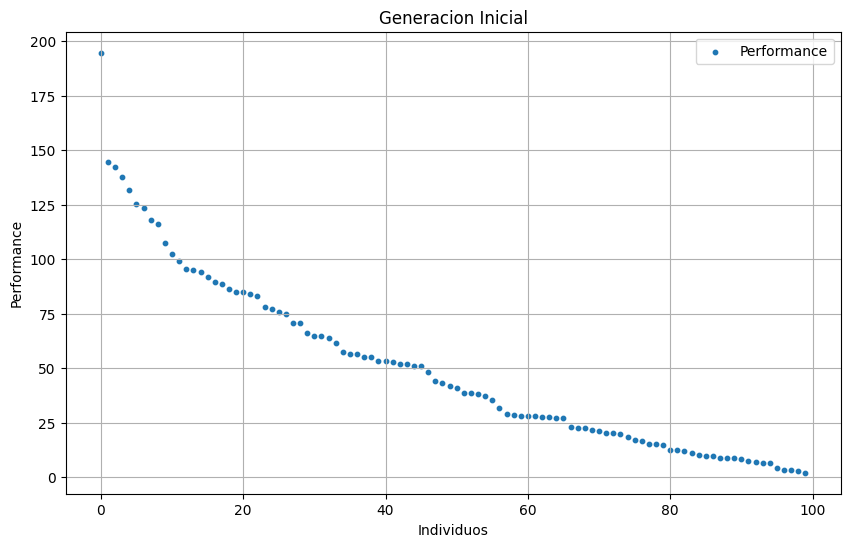

In [13]:
csv = 'generation0.csv'
titulo = 'Generacion Inicial'
graph(csv,titulo)

##### Selections

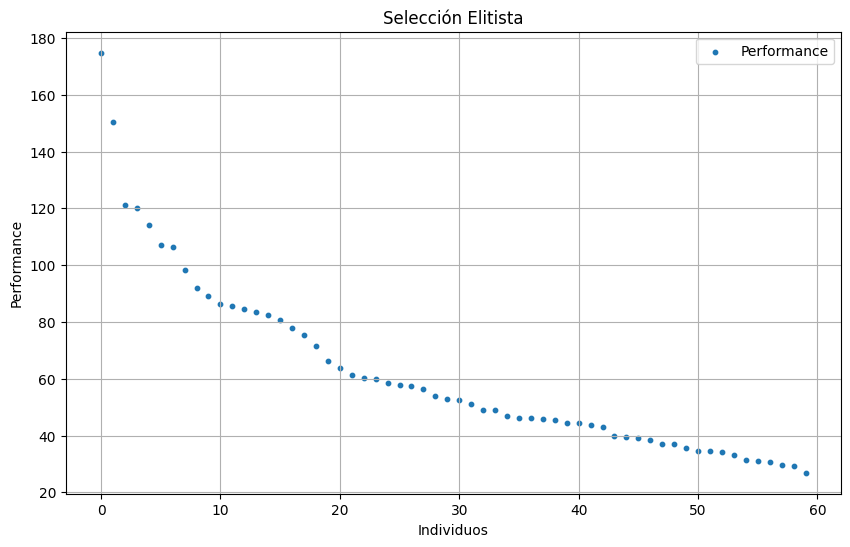

In [14]:
csv = 'elitist_selection.csv'
titulo = 'Selección Elitista'
graph(csv,titulo)

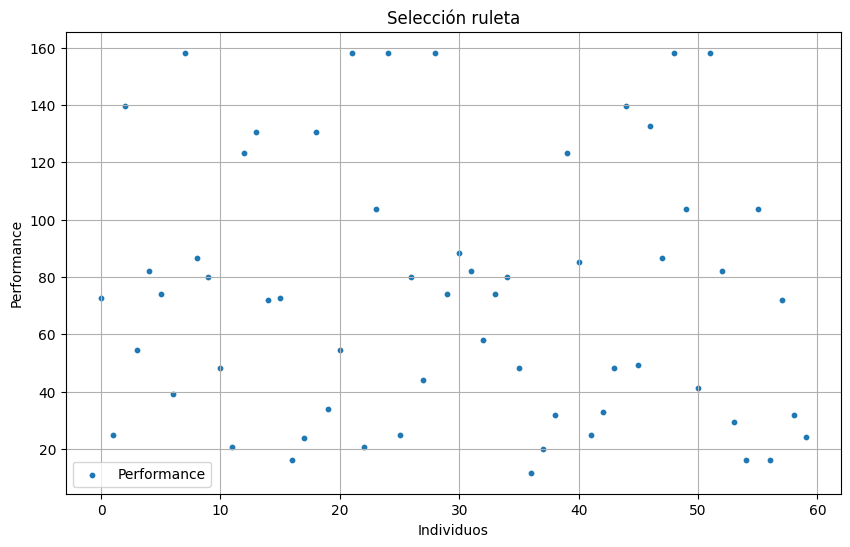

In [15]:
csv = 'roulette_wheel_selection.csv'
titulo = 'Selección ruleta'
graph(csv,titulo)

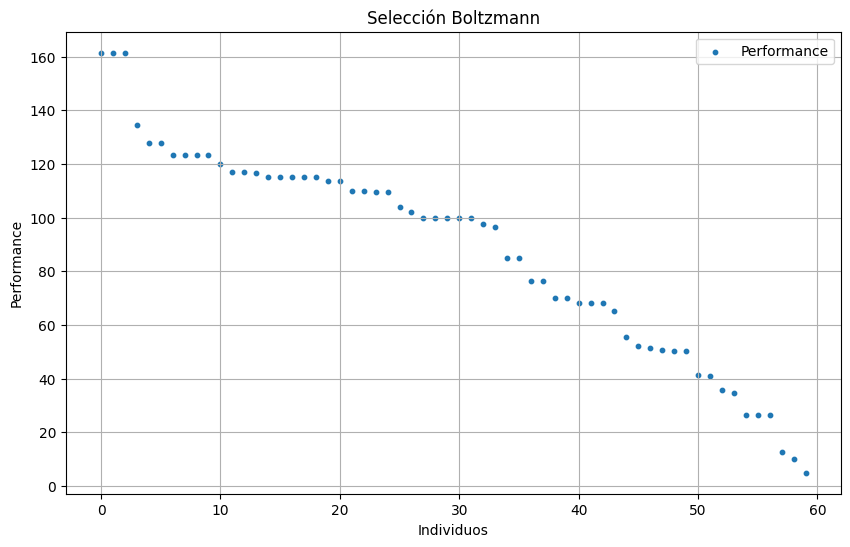

In [16]:
csv = 'boltzmann_selection.csv'
titulo = 'Selección Boltzmann'
graph(csv,titulo)

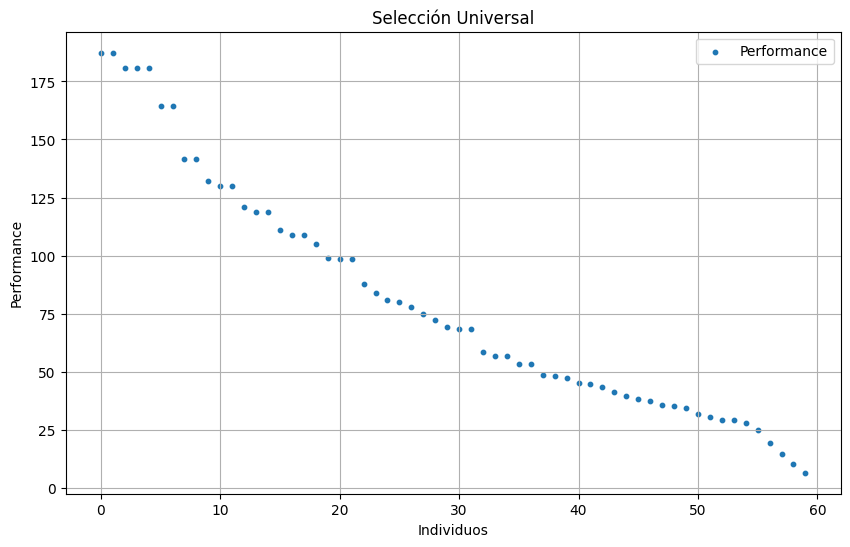

In [17]:
csv = 'universal_selection.csv'
titulo = 'Selección Universal'
graph(csv,titulo)

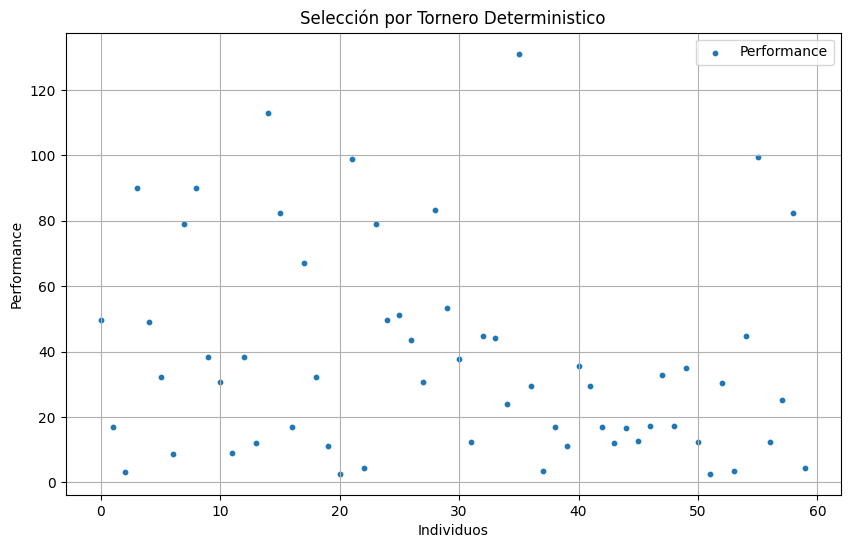

In [18]:
csv = 'deterministic_tournament.csv'
titulo = 'Selección por Tornero Deterministico'
graph(csv,titulo)

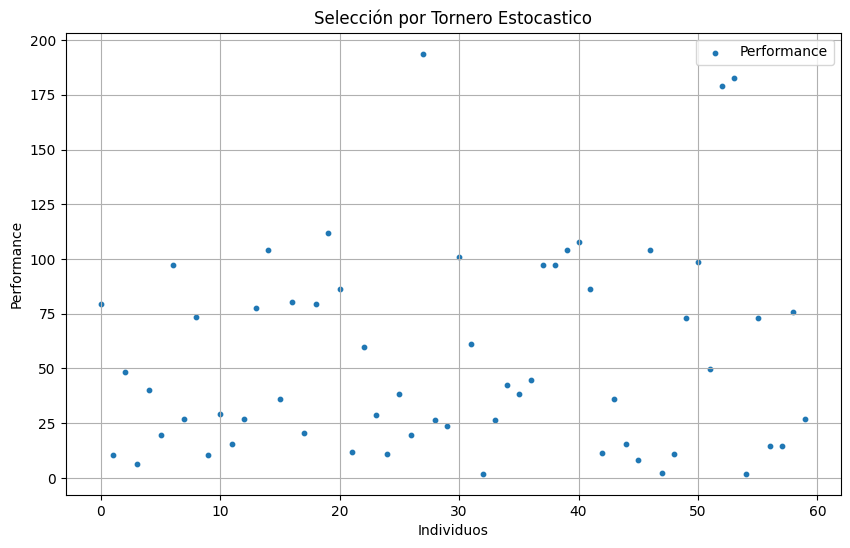

In [19]:
csv = 'stochastic_tournament_selection.csv'
titulo = 'Selección por Tornero Estocastico'
graph(csv,titulo)

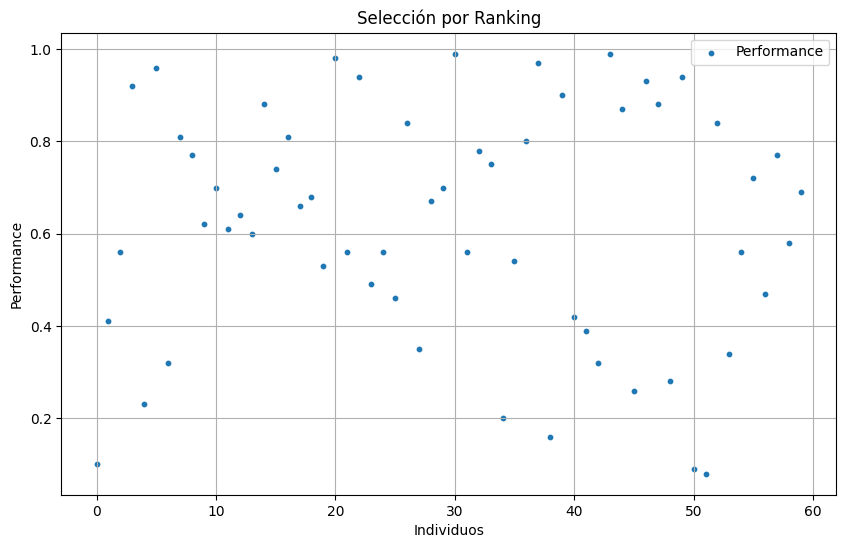

In [20]:
csv = 'rank_based_selection.csv'
titulo = 'Selección por Ranking'
graph(csv,titulo)


##### Crossovers

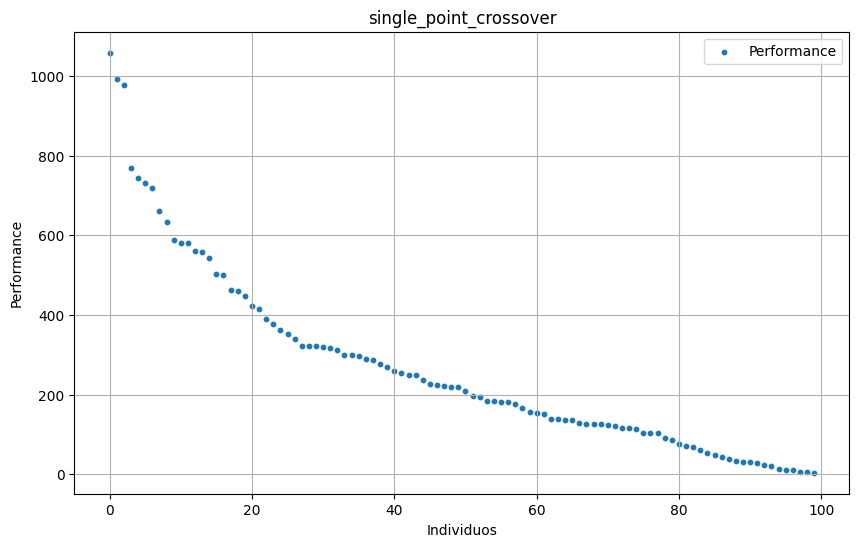

In [21]:
csv = 'single_point_crossover.csv'
titulo = 'single_point_crossover'
graph(csv,titulo)

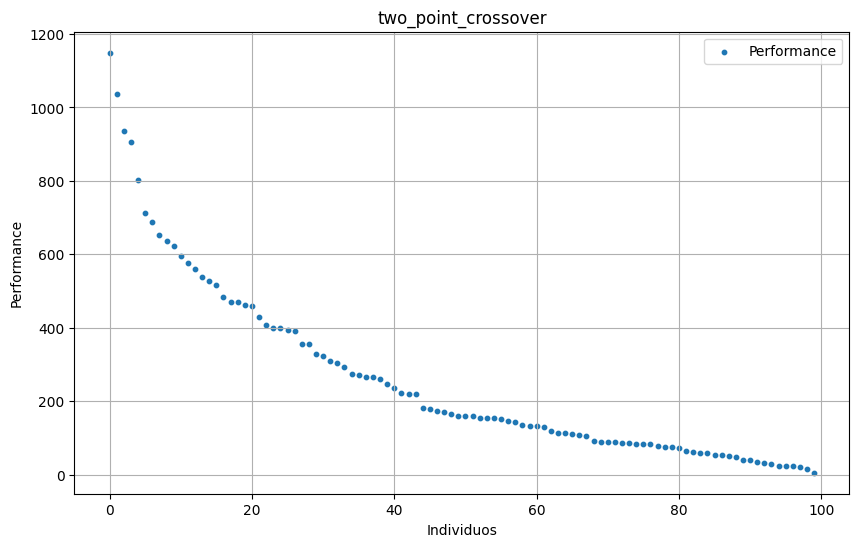

In [22]:
csv = 'two_point_crossover.csv'
titulo = 'two_point_crossover'
graph(csv,titulo)

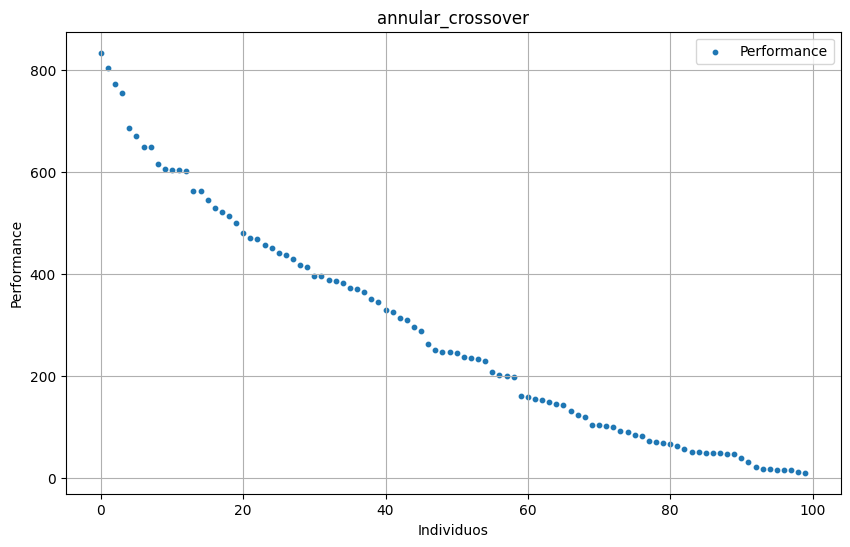

In [23]:
csv = 'annular_crossover.csv'
titulo = 'annular_crossover'
graph(csv,titulo)

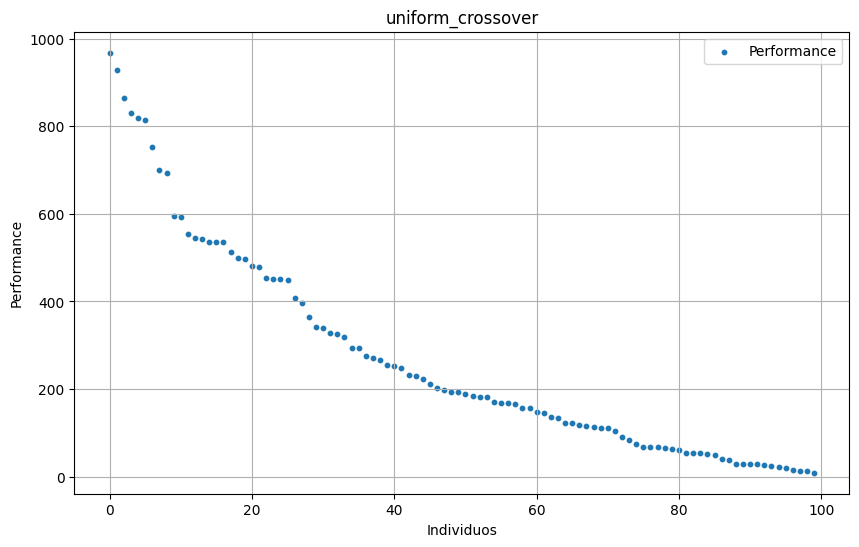

In [24]:
csv = 'uniform_crossover.csv'
titulo = 'uniform_crossover'
graph(csv,titulo)

##### Mutations

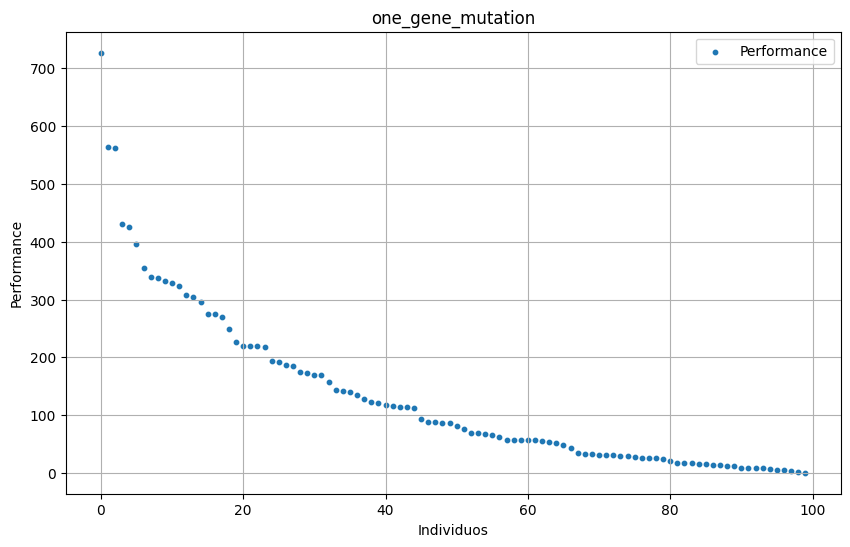

In [25]:
csv = 'one_gene_mutation.csv'
titulo = 'one_gene_mutation'
graph(csv,titulo)

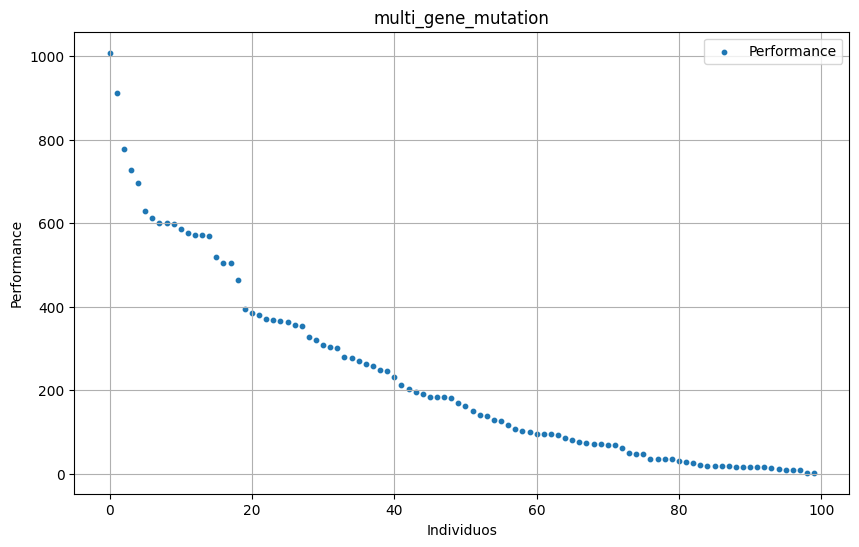

In [26]:
csv = 'multi_gene_mutation.csv'
titulo = 'multi_gene_mutation'
graph(csv,titulo)

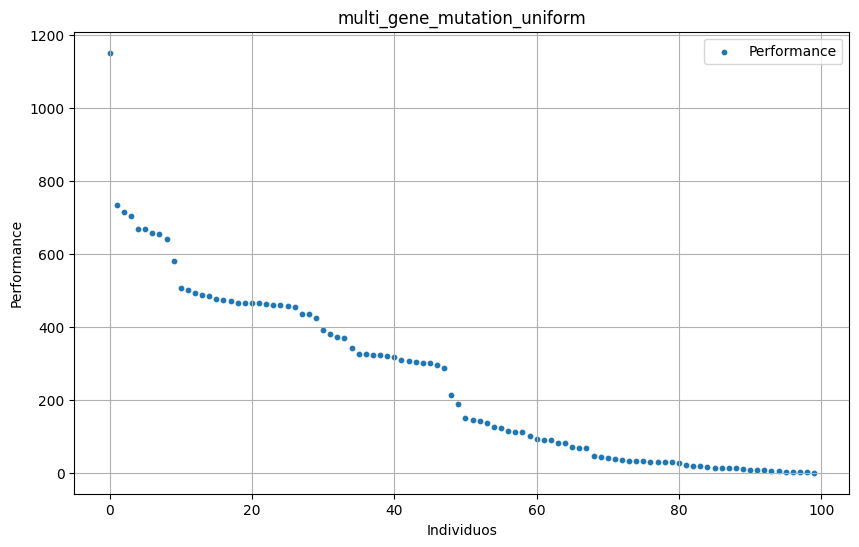

In [27]:
csv = 'multi_gene_mutation_uniform.csv'
titulo = 'multi_gene_mutation_uniform'
graph(csv,titulo)

##### Grafica del Motor AG

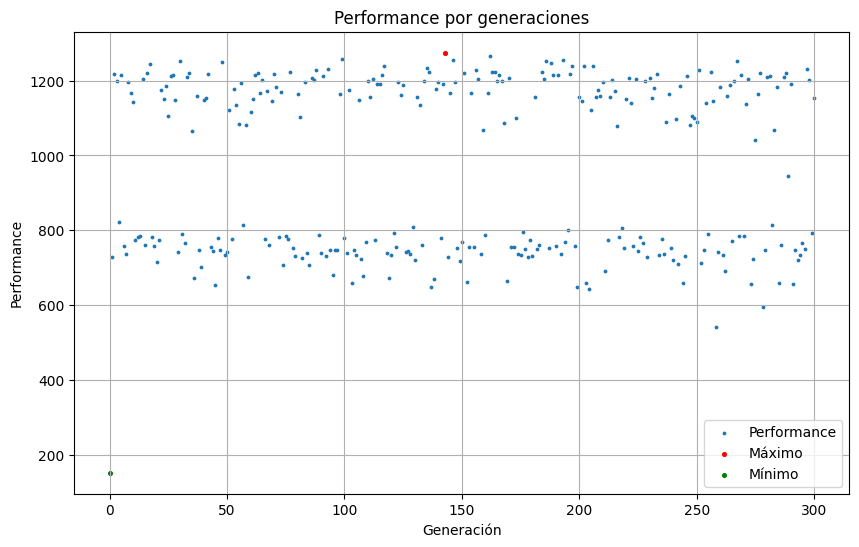

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos-Prueba1.csv")

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance por generaciones')
plt.legend()
plt.grid(True)
plt.show()